## Visualizing various Model Selection chain outputs

Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import json, pickle

In [3]:
import sys
sys.path.insert(0,'/Users/hazboun/software_development/la_forge/')
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec

In [4]:
psrname = 'J0030+0451'#'J1911+1347'
chaindir = '/Users/hazboun/nanograv_detection/ent_ext_testing/{}/nondiag_dmgp/'.format(psrname)

In [41]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection',
                     chaindir=chaindir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 2250
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


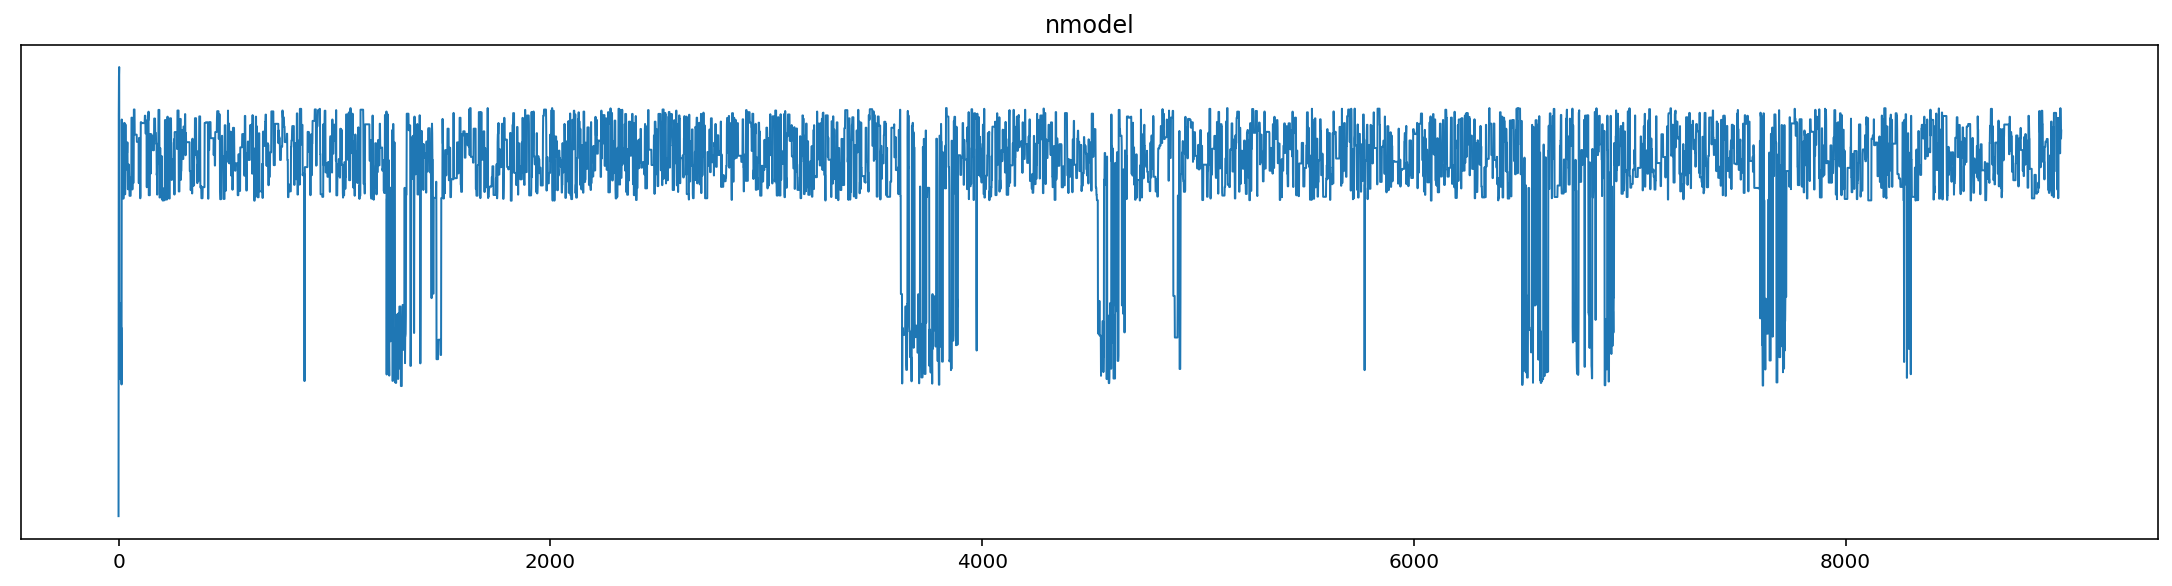

In [42]:
dg.plot_chains(cH,hist=False,pars=['nmodel'],ncols=1,
               title_y=1.05,suptitle='')

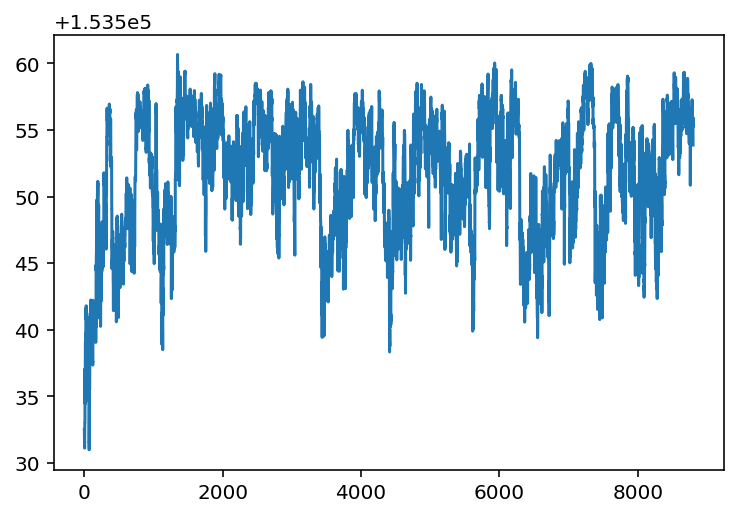

In [43]:
plt.plot(cH.get_param('lnlike',to_burn=False)[200:])
plt.show()

In [32]:
1/(7*24*3600)

1.6534391534391535e-06

In [7]:
with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_dict=json.load(fin)

In [8]:
# model_dict

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model. It is nice to look at how various parameters, say for achromatic RN or `ECORR`, change from model to model.

When a given pulsar analysis gets stuck in one of the `nmodel` parameters

In [13]:
c3=cH.model_core(3)
c4=cH.model_core(4)
c5=cH.model_core(5)

In [11]:
c5.params

['J1911+1347_430_PUPPI_efac',
 'J1911+1347_430_PUPPI_log10_ecorr',
 'J1911+1347_430_PUPPI_log10_equad',
 'J1911+1347_L-wide_PUPPI_efac',
 'J1911+1347_L-wide_PUPPI_log10_ecorr',
 'J1911+1347_L-wide_PUPPI_log10_equad',
 'J1911+1347_dm_gp_log10_ell',
 'J1911+1347_dm_gp_log10_gam_p',
 'J1911+1347_dm_gp_log10_p',
 'J1911+1347_dm_gp_log10_sigma',
 'J1911+1347_red_noise_gamma',
 'J1911+1347_red_noise_log10_A',
 'n_earth']

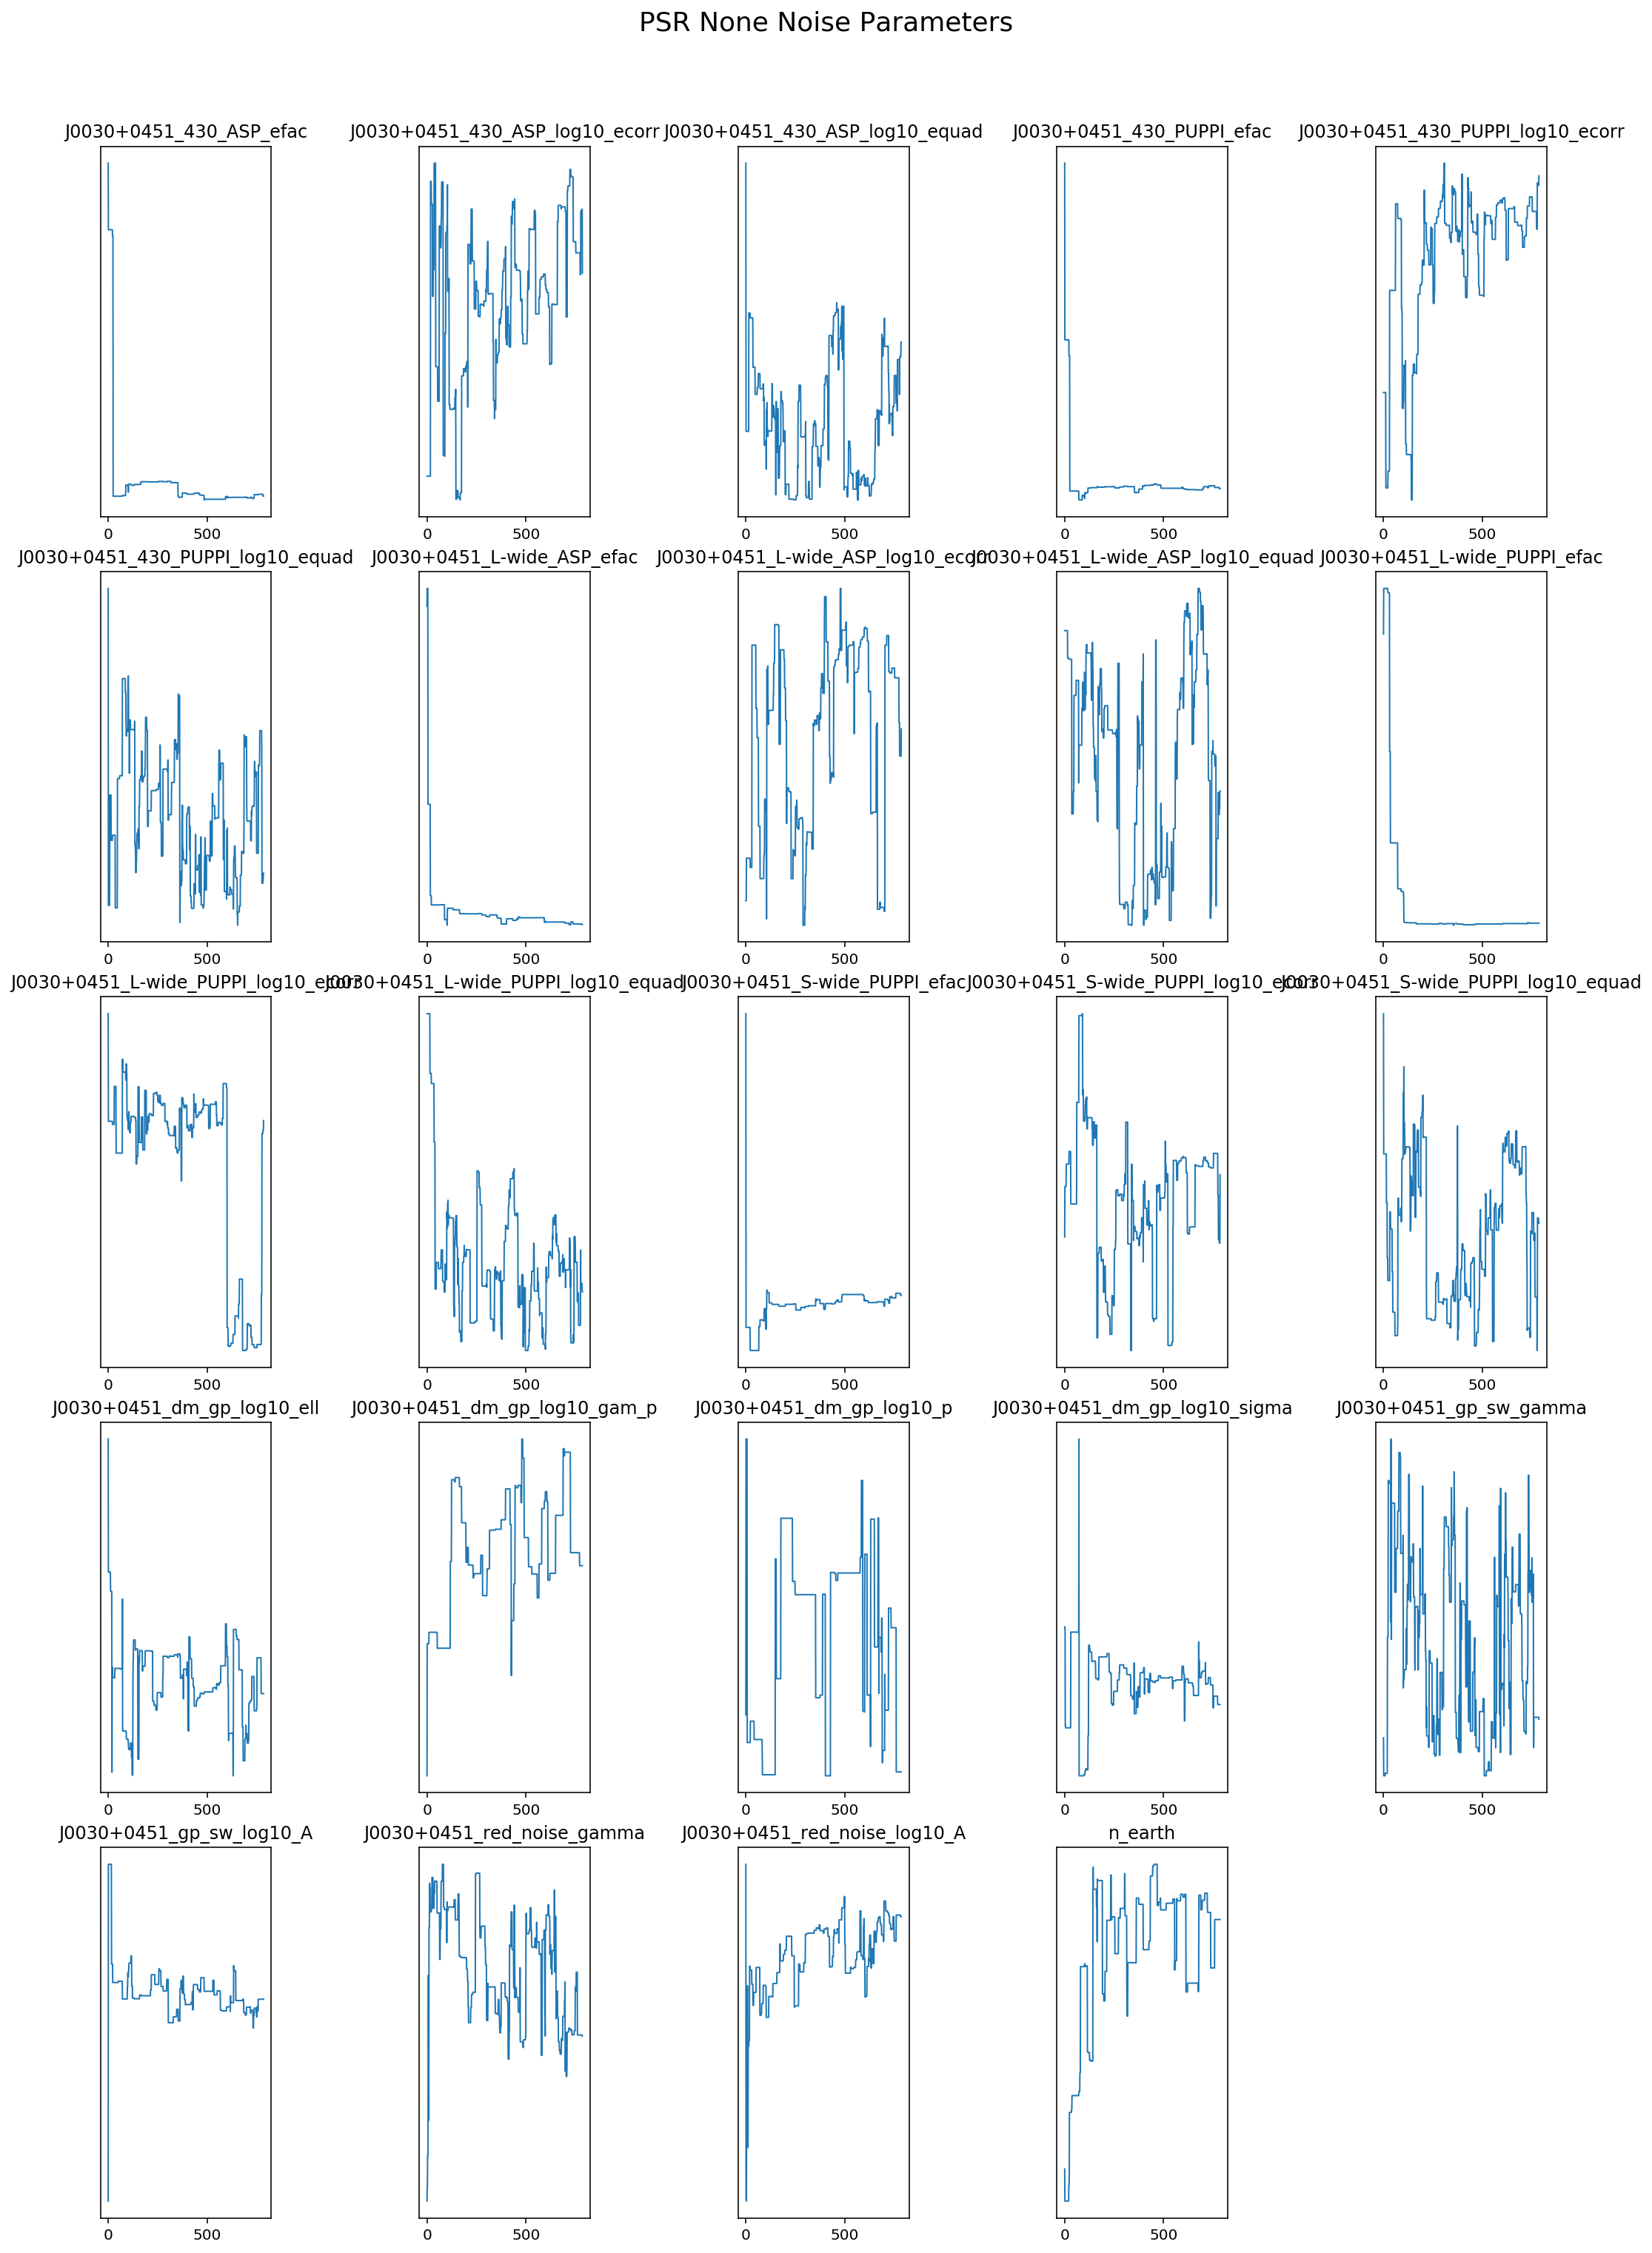

In [14]:
dg.plot_chains(c4, hist=False, ncols=5, title_y=1.05)

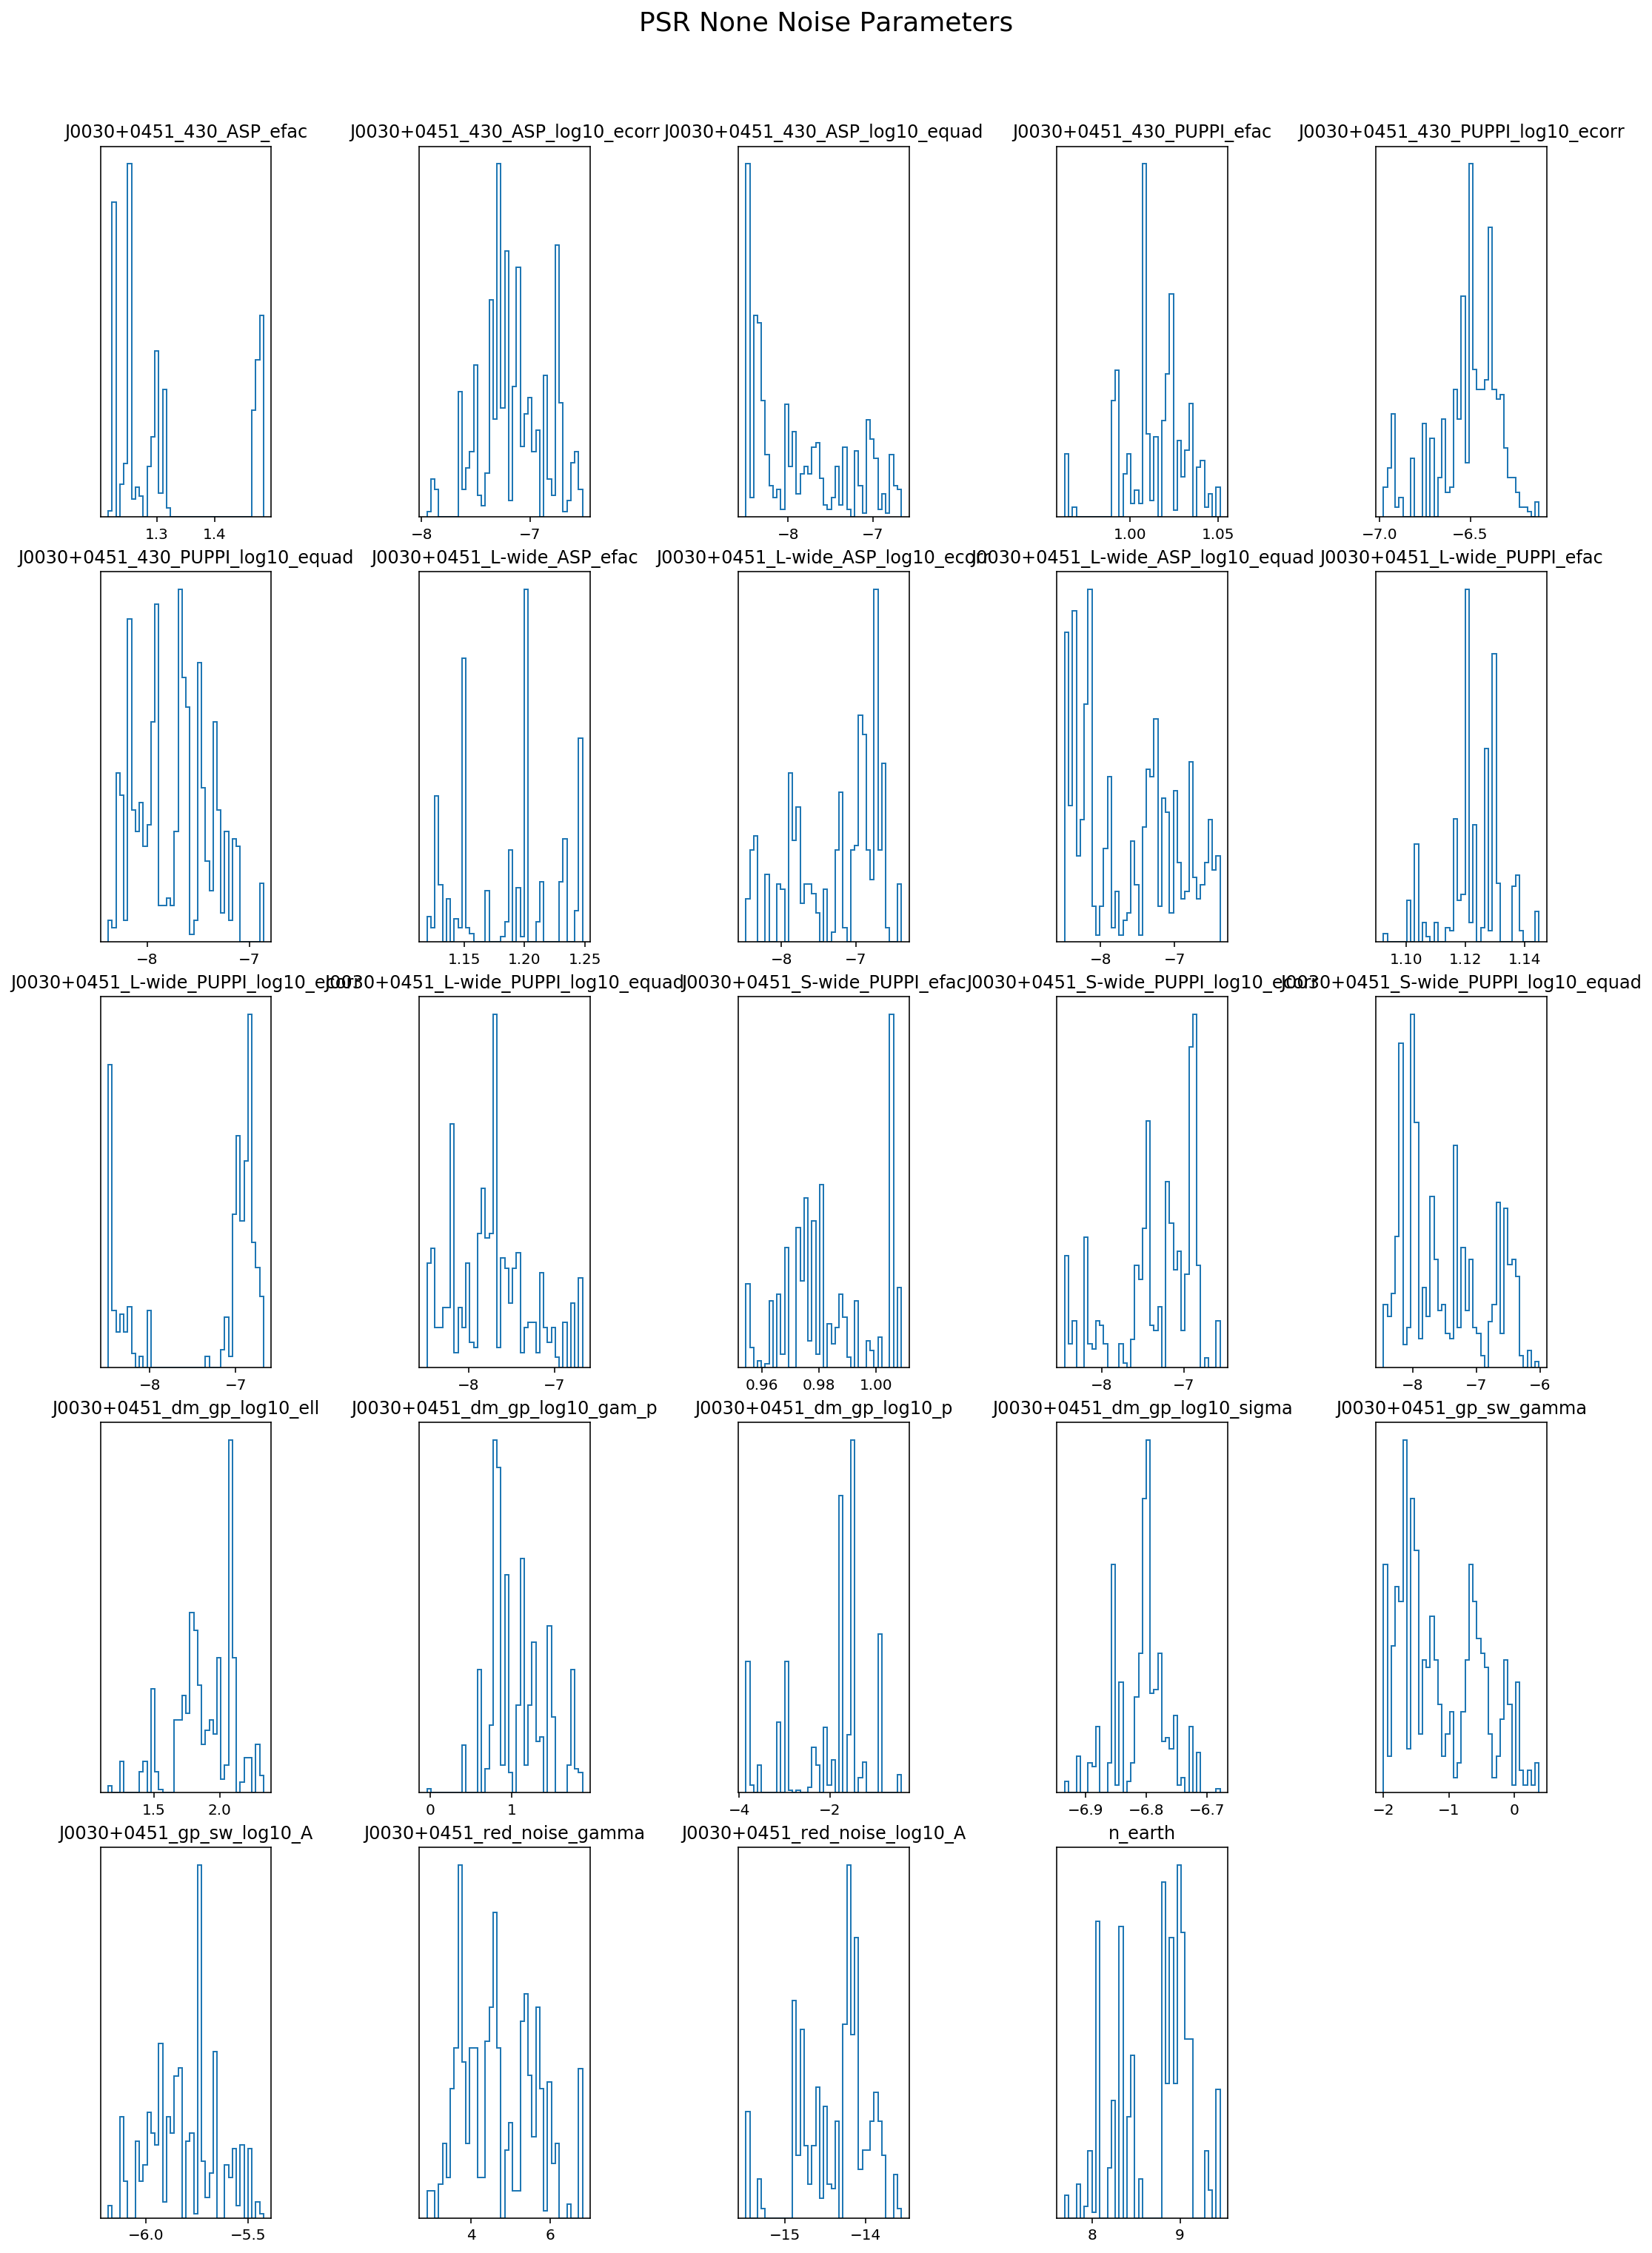

In [15]:
dg.plot_chains(c4, hist=True, ncols=5, title_y=1.05)

In [11]:
with open(chaindir+'/model_labels.json' , 'r') as fin:
    model_labels= json.load(fin)

model_labels

[['A', 'powerlaw', None, True],
 ['B', 'powerlaw', None, False],
 ['C', 'powerlaw', 'sq_exp', True],
 ['D', 'powerlaw', 'sq_exp', False],
 ['E', 'powerlaw', 'periodic', True],
 ['F', 'powerlaw', 'periodic', False]]

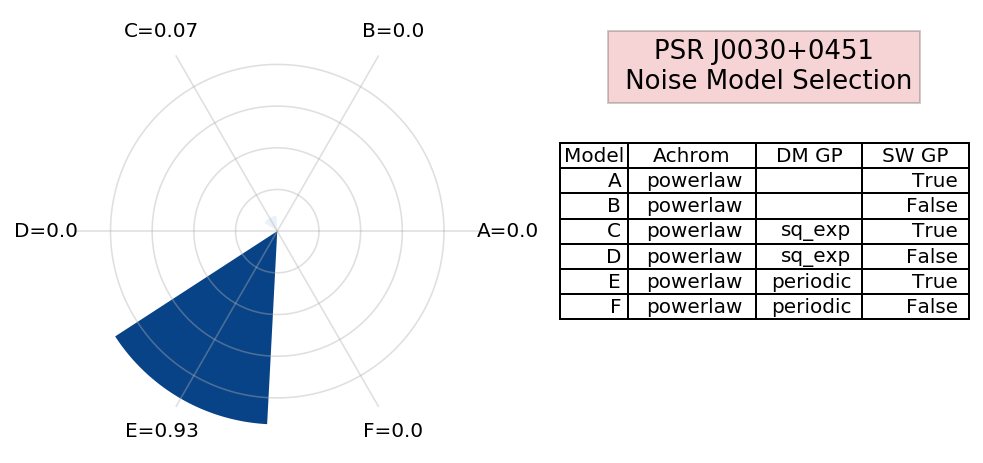

In [44]:
dg.noise_flower(cH, 
                colLabels=['Model','Achrom', 'DM GP', 'SW GP'],
                cellText=model_labels,
                colWidths=[0.16,0.3,0.25,0.25])

In [ ]:
plt.table()

## Plot DMX

## Gaussian Process Realizations

In [16]:
from enterprise_extensions.models import model_singlepsr_noise
# from enterprise_extensions.chromatic import solar_wind, chromatic

In [17]:
from la_forge.gp import Signal_Reconstruction as gp

In [18]:
psrname = 'J1911+1347'
filepath = './no_dmx_pickles/'
filepath += '{0}_ng12p5yr_v3_nodmx_ePSR.pkl'.format(psrname)

In [19]:
with open(filepath,'rb') as fin:
    psr=pickle.load(fin)

with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_kwargs=json.load(fin)

In [20]:
ptas = {}
for ky, kwargs in model_kwargs.items():
    ptas[int(ky)] = model_singlepsr_noise(psr, **kwargs)

powerlaw
powerlaw


The `Signal_Reconstruction` class take an `enterprise.pulsar.Pulsar` object, an `enterprise.signal_base.PTA` object and a `la_forge.core.Core` object as inputs. (One can alternatively use a chain array and burn value for the latter.) 

In [82]:
sr=gp(psr,ptas[5],core=c5)

The `gp_types` atribute will tell you which Gaussian process signals are available in this `PTA`. Additionally there are a number of other options one can use for the `gp_type` flag that goes into a signal reconstruction. These include `['achromatic_rn','DM','FD','all']`. Also any of the timing parameter perturbations can also be called. 

In [83]:
sr.gp_types

['linear_timing_model', 'red_noise', 'dm_gp']

In [84]:
psr.fitpars

['Offset',
 'ELONG',
 'ELAT',
 'F0',
 'F1',
 'DM',
 'DM1',
 'DM2',
 'PMELONG',
 'PMELAT',
 'PX',
 'FD1',
 'FD2',
 'JUMP1']

In [85]:
idxs = np.random.randint(sr.burn, sr.chain.shape[0],size=100)

In [86]:
DM = np.array([sr.reconstruct_signal(gp_type='DM',det_signal=True, idx=idx)['J1911+1347']
               for idx in idxs])

In [87]:
dm_gp = np.array([sr.reconstruct_signal(gp_type='dm_gp', idx=idx)['J1911+1347']
                  for idx in idxs])

In [88]:
mlvDM = sr.reconstruct_signal(gp_type='DM',det_signal=True, mle=True)['J1911+1347']
mlv_dmgp =sr.reconstruct_signal(gp_type='dm_gp', mle=True)['J1911+1347']

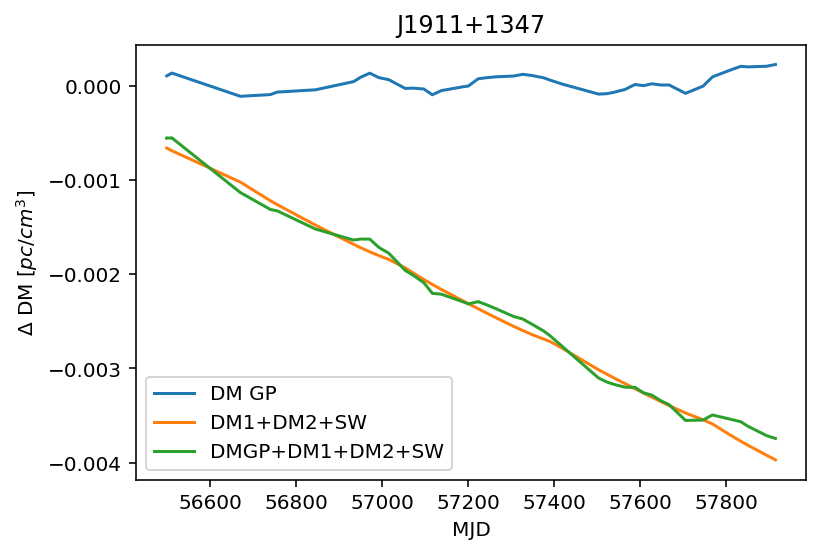

In [97]:
# for dm in dmgp:
#     plt.plot(psr.toas/(24*3600),dm,'x',linewidth=0.2,alpha=0.4,color='gray')
plt.plot(psr.toas/(24*3600),(mlv_dmgp*psr.freqs**2*2.41e-4),label='DM GP')
plt.plot(psr.toas/(24*3600),(mlvDM*psr.freqs**2*2.41e-4),label='DM1+DM2+SW')

plt.plot(psr.toas/(24*3600),((mlv_dmgp+mlvDM)*psr.freqs**2*2.41e-4),label='DMGP+DM1+DM2+SW')
# plt.ylim(-10,10)
plt.legend(loc='lower left')
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

In [90]:
#Load DMX values
dtypes = {'names': ('DMXEP', 'DMX_value', 'DMX_var_err', 
                    ' DMXR1', ' DMXR2', ' DMXF1', 
                    ' DMXF2', ' DMX_bin'),
          'formats': ('f4','f4','f4','f4','f4','f4','f4','U6')}
dmx=np.loadtxt('./dmx/{0}_NANOGrav_12yv3.dmx'.format(psrname),
               skiprows=4,
               dtype=dtypes)

In [91]:
dm_units = (dm_gp + DM)*psr.freqs[np.newaxis,:]**2*2.41e-4
dm_mlv = (mlvDM + mlv_dmgp)*psr.freqs**2*2.41e-4

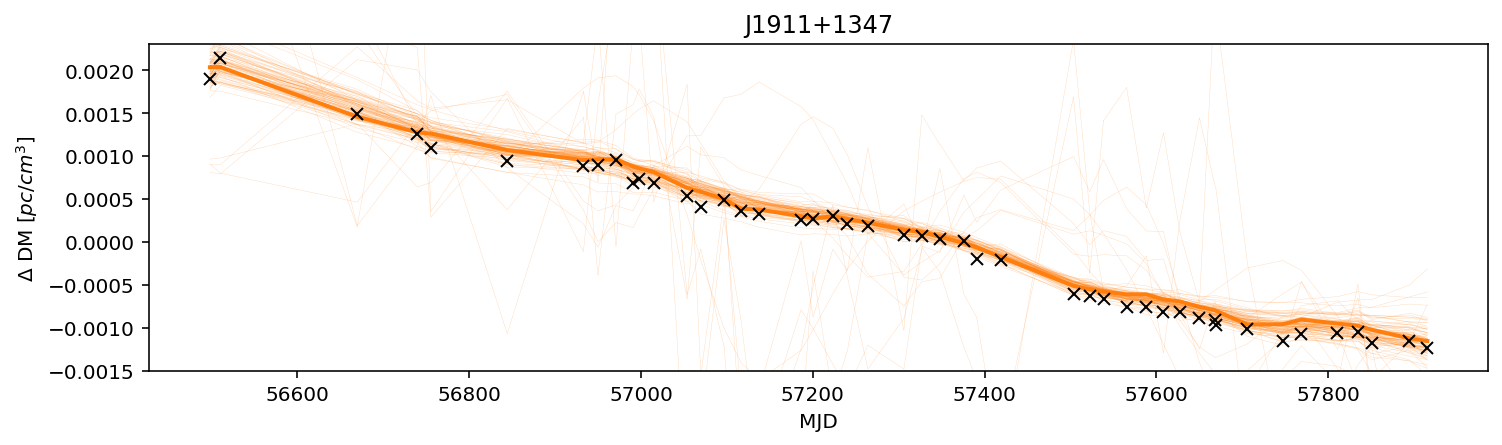

In [92]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mlv-dm_mlv.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')
plt.ylim(-0.0015,0.0023)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

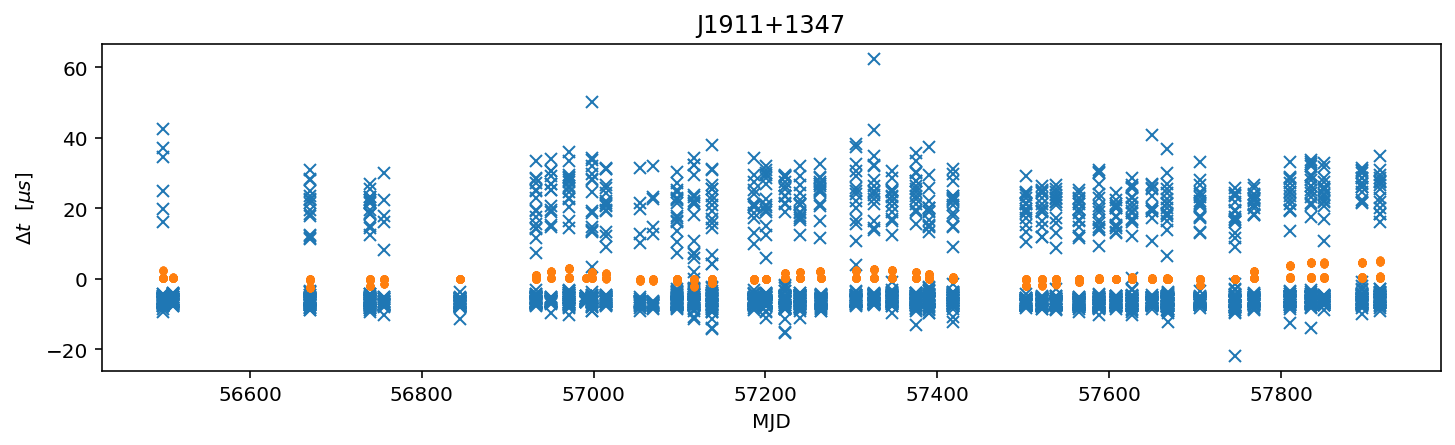

In [96]:
quadDM_resids = psr.residuals-mlvDM-(psr.residuals-mlvDM).mean()

plt.figure(figsize=[12,3])
plt.plot(psr.toas/(24*3600),quadDM_resids*1e6,'x')
plt.plot(psr.toas/(24*3600),mlv_dmgp*1e6,'.')
# plt.ylim(-10,10)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta t$  [$\mu s$]')
plt.title(psrname)
plt.show()